# Proyek Klasifikasi Gambar: Handwritten Digits 0 - 9 (https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9)
- **Nama:** Nanda Arya Putra
- **Email:** nandaarya404@gmail.com
- **ID Dicoding:** nandaaryaputra

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import matplotlib.pyplot as plt
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
# Libraries untuk pemrosesan data gambar
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Loading

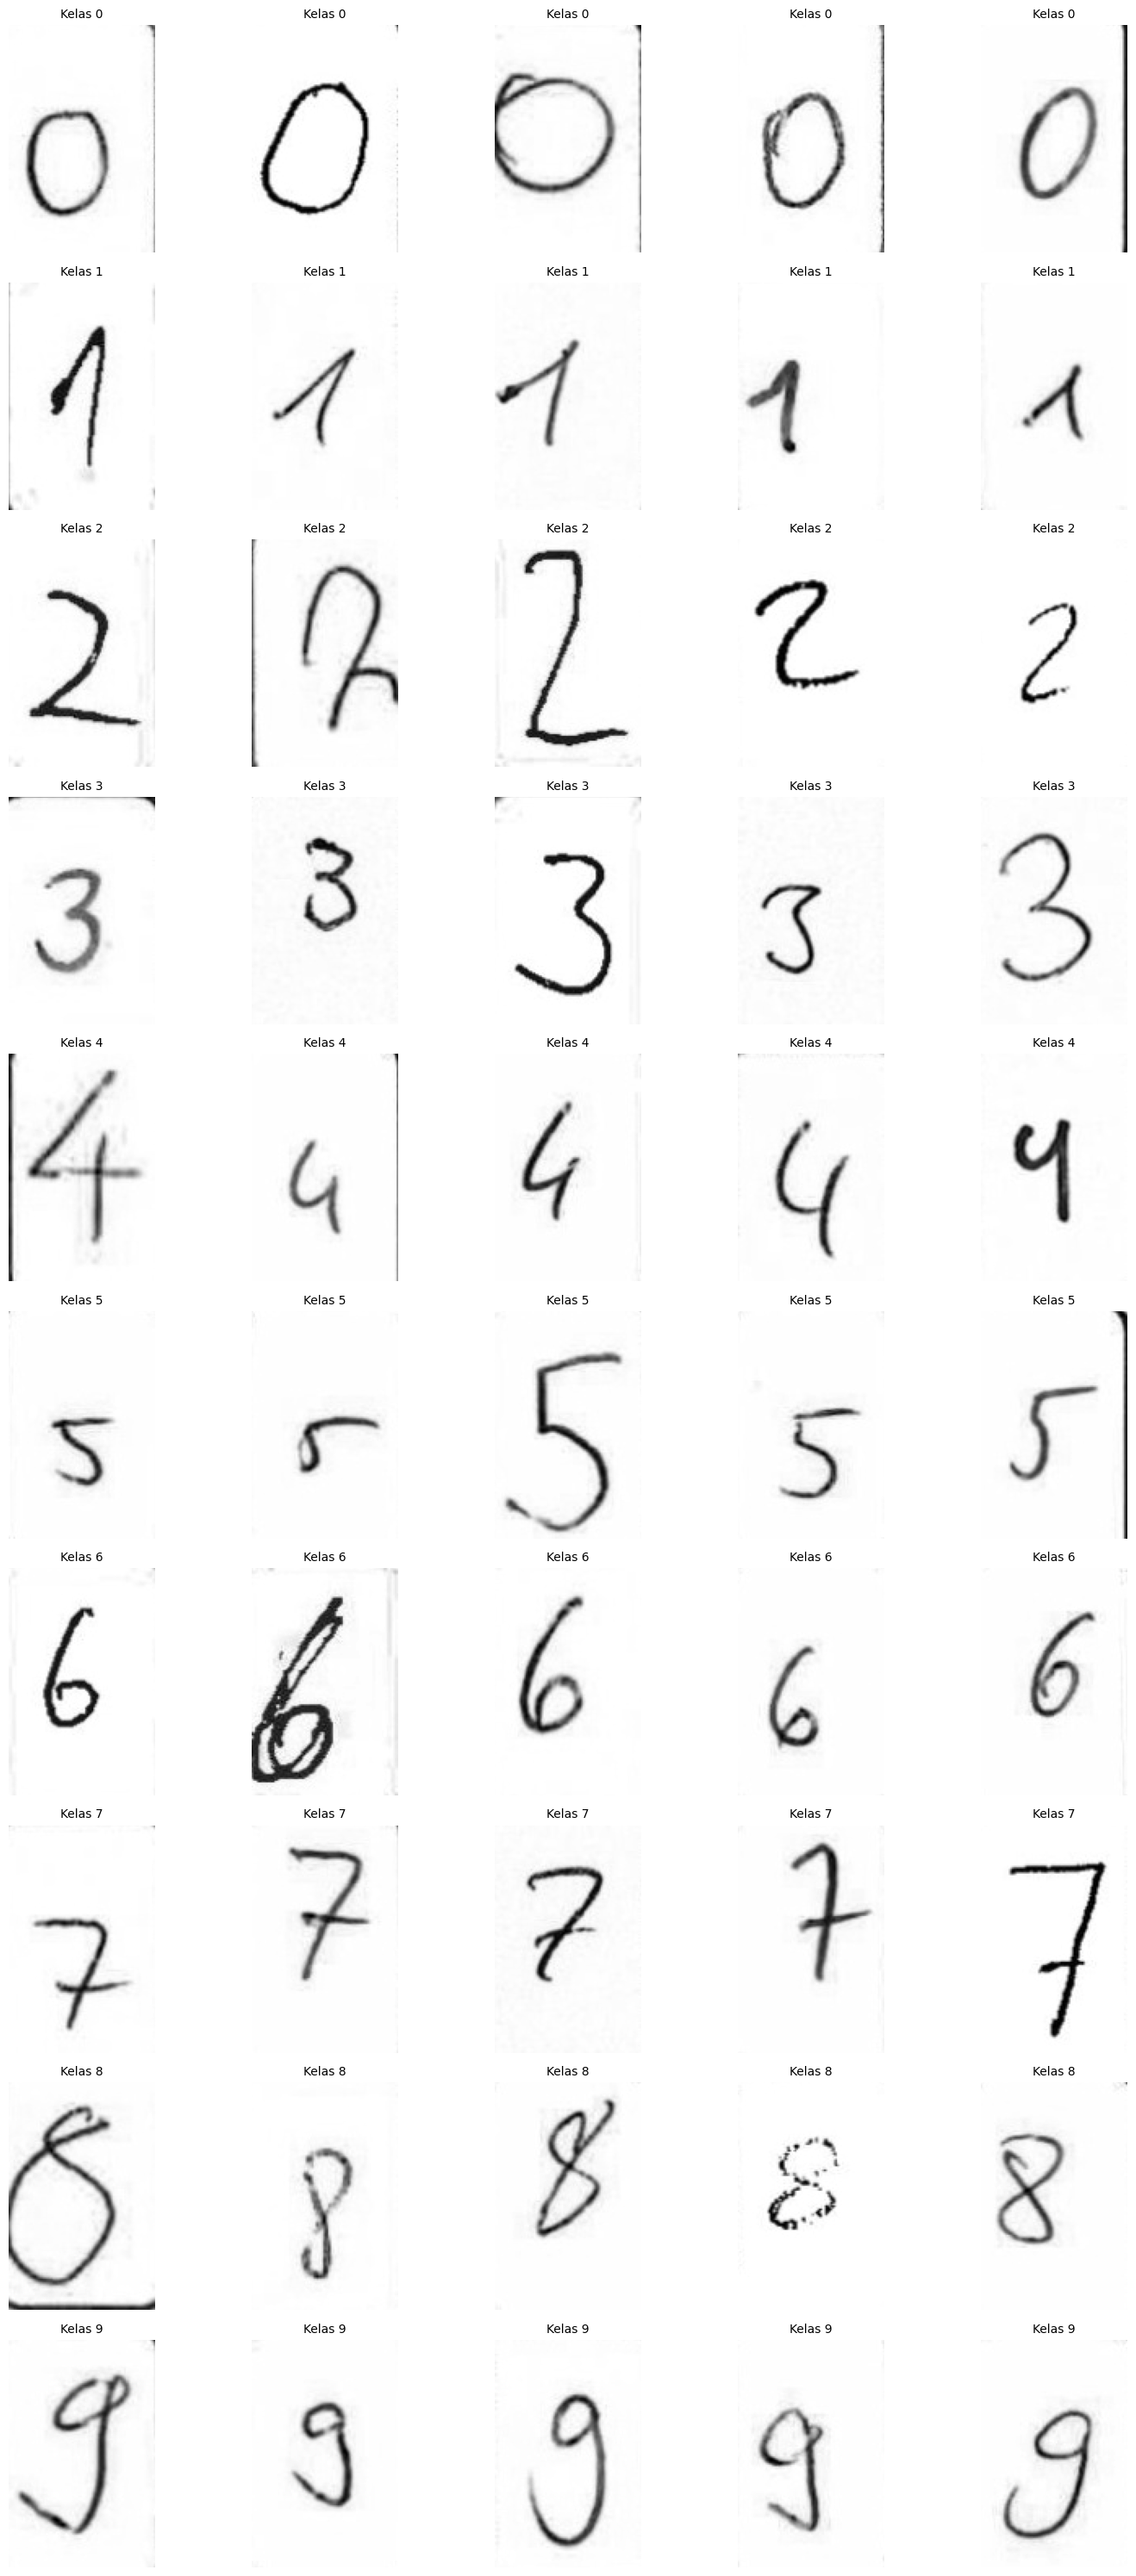

In [3]:
data_dir = "/kaggle/input/handwritten-digits-0-9"

digit_images = {}

# Loop melalui folder 0-9
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    image_files = os.listdir(folder_path)
    digit_images[str(label)] = image_files

# Menampilkan 5 gambar per kelas
fig, axes = plt.subplots(10, 5, figsize=(15, 30))

for label, image_files in digit_images.items():
    # Pilih 5 gambar acak dari kelas ini
    chosen_images = np.random.choice(image_files, 5, replace=False)

    for i, image_file in enumerate(chosen_images):
        image_path = os.path.join(data_dir, label, image_file)
        try:
            # Baca gambar menggunakan cv2
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Tampilkan gambar pada subplot yang sesuai
            ax = axes[int(label), i]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Kelas {label}", fontsize=10)
            ax.axis('off')
        except Exception as e:
            print(f"Error reading image {image_path}: {e}")

plt.tight_layout()
plt.show()

## Data Preparation

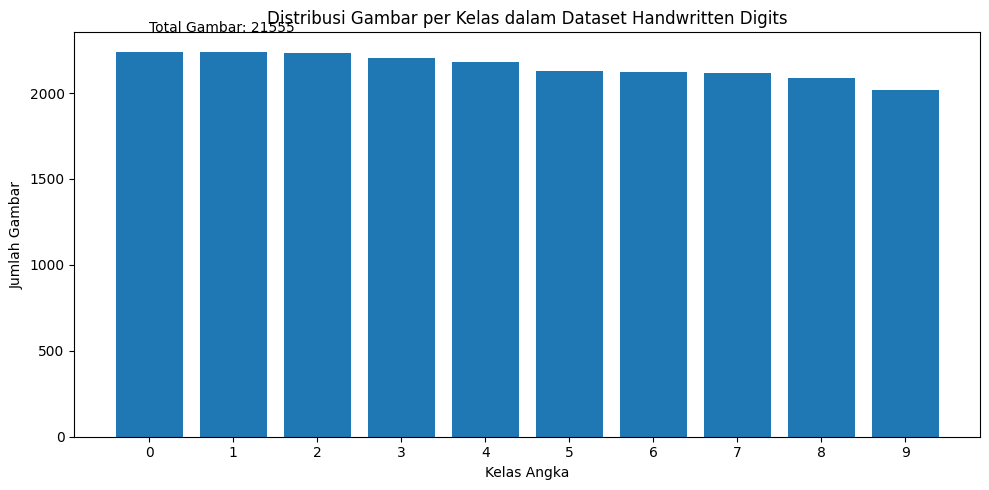

Total Gambar dalam Dataset: 21555


In [4]:
data_dir = "/kaggle/input/handwritten-digits-0-9"

# Dictionary untuk menyimpan jumlah gambar per kelas
digit_counts = {}

# Loop melalui folder 0-9 dan hitung gambar per kelas
total_images = 0
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    image_files = os.listdir(folder_path)
    digit_counts[str(label)] = len(image_files)
    total_images += len(image_files)

# Membuat plot distribusi
labels = list(digit_counts.keys())
counts = list(digit_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.xlabel("Kelas Angka")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Gambar per Kelas dalam Dataset Handwritten Digits")
plt.xticks(labels)

# Menampilkan jumlah total gambar
plt.text(0, max(counts) * 1.05, f"Total Gambar: {total_images}", ha='left') 

plt.tight_layout()
plt.show()

print(f"Total Gambar dalam Dataset: {total_images}")

### Data Preprocessing

In [5]:
data_dir = "/kaggle/input/handwritten-digits-0-9"

# List untuk menyimpan gambar dan label
images = []
labels = []

for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        try:
            # Baca gambar dalam skala abu-abu
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error reading image {image_path}: {e}")

# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)

# Reshape gambar (sesuai dengan ukuran dataset 90x140)
images = images.reshape(-1, 90, 140, 1)

# Normalisasi data
images = images.astype("float32") / 255.0

# One-hot encode label
labels = keras.utils.to_categorical(labels, num_classes=10)

print("Preprocessing data selesai.")

Preprocessing data selesai.


In [6]:
# Buat array indeks sepanjang dataset
indices = np.arange(len(images))

# Acak indeks
np.random.seed(42)
np.random.shuffle(indices)

# Acak images dan labels menggunakan indeks yang sudah diacak
images = images[indices]
labels = labels[indices]

#### Split Dataset

In [7]:
# Split data secara stratified
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test: {len(X_test)}")

# Membuat DataFrame dari label train dan test
df_train = pd.DataFrame({'label': np.argmax(y_train, axis=1)})
df_test = pd.DataFrame({'label': np.argmax(y_test, axis=1)})

# Menampilkan jumlah data train dan test untuk setiap label
print("Jumlah data train untuk setiap label:")
print(df_train['label'].value_counts())

print("\nJumlah data test untuk setiap label:")
print(df_test['label'].value_counts())

Jumlah data train: 17244
Jumlah data test: 4311
Jumlah data train untuk setiap label:
label
1    1793
0    1789
2    1786
3    1761
4    1743
5    1701
6    1697
7    1693
8    1668
9    1613
Name: count, dtype: int64

Jumlah data test untuk setiap label:
label
1    448
2    447
0    447
3    441
4    436
5    425
6    424
7    423
8    417
9    403
Name: count, dtype: int64


## Modelling

In [8]:
model = Sequential([
    # First Conv Block
    Conv2D(32, (3, 3), padding='same', activation='relu', 
           kernel_regularizer=tf.keras.regularizers.l2(1e-4),
           input_shape=(90, 140, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    # Second Conv Block
    Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    # Third Conv Block
    Conv2D(128, (3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    # Dense Layers
    Flatten(),
    Dense(256, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile dengan learning rate yang lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the Model Architecture
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 90, 140, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 140, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 140, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 140, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 70, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 70, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 70, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 70, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 70, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 45, 70, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 22, 35, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 22, 35, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 22, 35, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 22, 35, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 11, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,451,818 (24.61 MB)

 Trainable params: 6,450,154 (24.61 MB)

 Non-trainable params: 1,664 (6.50 KB)

None


## Evaluasi dan Visualisasi

In [9]:
# Callback untuk menghentikan pelatihan
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        mode='max'
    )
]

In [10]:
# Training Model
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks, shuffle=True)

Epoch 1/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.1796 - loss: 3.0886 - val_accuracy: 0.3869 - val_loss: 1.8720 - learning_rate: 1.0000e-04
Epoch 2/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.5331 - loss: 1.5664 - val_accuracy: 0.5832 - val_loss: 1.5680 - learning_rate: 1.0000e-04
Epoch 3/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6857 - loss: 1.0663 - val_accuracy: 0.8082 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 4/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.7583 - loss: 0.8404 - val_accuracy: 0.8065 - val_loss: 0.7086 - learning_rate: 1.0000e-04
Epoch 5/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.8014 - loss: 0.7140 - val_accuracy: 0.8701 - val_loss: 0.5056 - learning_rate: 1.0000e-04
Epoch 6/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.8385 - loss: 0.6025 - val_accuracy: 0.8578 - val_loss: 0.5607 - learning_rate: 1.0000e-04
Epoch 7/30
539/539 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/ste

In [11]:
# Setelah training selesai, simpan model dalam format SavedModel
model.export('/kaggle/working/saved_model')

Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 90, 140, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132985354040448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985353996416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985353999232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985353997472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985353997296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985353998528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985354002752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985354000816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985354001168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132985354002576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132

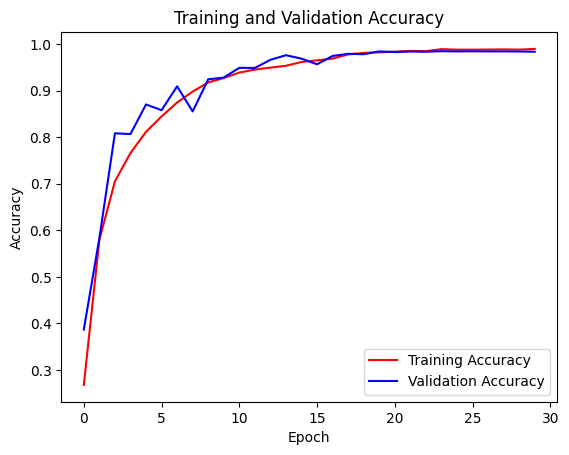

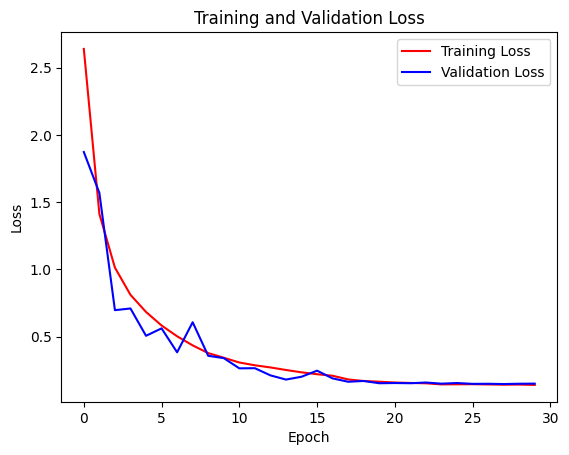

In [12]:
# Visualisasi hasil training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Konversi Model

In [13]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requ

In [14]:
# Konversi Model SavedModel ke TFJS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /kaggle/working/saved_model \
    /kaggle/working/model_tfjs

2025-02-09 15:36:30.712695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 15:36:30.733607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-09 15:36:30.739587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1739115395.937613     608 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739115395.938086     608 cuda_executor.cc:1015] succ

In [15]:
# Convert Model SavedModel to TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/saved_model')
tflite_model = converter.convert()
 
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)